# classiq

In [5]:
%pip install qiskit
%pip install classiq
%pip install nest_asyncio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 39.0 MB/s 
     |████████████████████████████████| 19.2 MB 4.9 MB/s 
     |████████████████████████████████| 240 kB 58.3 MB/s 
     |████████████████████████████████| 106 kB 52.3 MB/s 
     |████████████████████████████████| 55 kB 3.6 MB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
     |████████████████████████████████| 37.5 MB 1.3 MB/s 
     |████████████████████████████████| 943 kB 53.1 MB/s 
     |████████████████████████████████| 4.1 MB 37.7 MB/s 
     |████████████████████████████████| 1.9 MB 54.9 MB/s 
     |████████████████████████████████| 112 kB 50.8 MB/s 
  Created wheel for qiskit: filename=qiskit-0.39.2-py3-none-any.whl size=12224 sha256=124015b758c8beb9fbc1befda88d76b85c05107d216845ff682096ebded1cbbb
  Stored in directory: /root/.cache/pip/wheels/30/dc/90/0ee5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import nest_asyncio
nest_asyncio.apply()
import classiq

classiq.authenticate()

Your user code: MPPR-XWTX
If a browser doesn't automatically open, please visit the url: https://classiq.eu.auth0.com/activate?user_code=MPPR-XWTX


In [7]:
from classiq import ModelDesigner, Executor
from classiq.builtin_functions import UCC, HartreeFock

from classiq.interface.chemistry.molecule import Molecule
from classiq.interface.chemistry.ground_state_problem import GroundStateProblem
from classiq.interface.backend.backend_preferences import (
    IBMBackendPreferences,
    IBMBackendProvider,
)
from classiq.interface.executor.execution_preferences import ExecutionPreferences, OptimizerPreferences
from classiq.interface.executor.hamiltonian_minimization_problem import HamiltonianMinimizationProblem
from classiq.interface.executor.quantum_instruction_set import QuantumInstructionSet
from classiq.interface.executor.quantum_program import QuantumProgram
from classiq.interface.chemistry.operator import PauliOperator
from classiq import ModelDesigner
from classiq.builtin_functions import HardwareEfficientAnsatz

## Prepare simulator

In [8]:
def define_simulator(simulator_name):
    if(simulator_name == "qasm" or simulator_name == "QASM"):
      curr_simulator = "qasm_simulator"
    else:
      curr_simulator = "aer_simulator_statevector"
    return curr_simulator

In [9]:
def define_optimizer(optimizer_name):
    if(optimizer_name == "cobyla" or optimizer_name == "COBYLA"):
      curr_optimizer = "COBYLA"
    else:
      curr_optimizer = "L_BFGS_B"
    return curr_optimizer

In [10]:
def prepare_simulator_classiq(curr_simulator, curr_optimizer,num_of_qubits=2, anzatz_first_gate = "x"):
    NUM_QUBITS = num_of_qubits
    FULLY_CONNECTED_MESH = [[0, 1]]
    hwea_params = HardwareEfficientAnsatz(
        num_qubits=NUM_QUBITS,
        connectivity_map=FULLY_CONNECTED_MESH,
        one_qubit_gates=[anzatz_first_gate, "ry"],
        two_qubit_gates="cx",
        reps=3,
    )

    model_designer = ModelDesigner()
    model_designer.HardwareEfficientAnsatz(params=hwea_params)
    circuit = model_designer.synthesize()
    #circuit.show()
    circuit_qasm = circuit.qasm
    optimizer_preferences = OptimizerPreferences(
        max_iteration=60,
        name = curr_optimizer
    )

    ibm_provider = IBMBackendProvider(
        #insert your information
    )

    backend_preferences = IBMBackendPreferences(
        backend_name=curr_simulator,
        access_token = "insert your information" ,
        provider=ibm_provider,
    )

    num_shots = 8192

    execution_preferences = ExecutionPreferences(
        num_shots=num_shots,
        backend_preferences=backend_preferences,
        optimizer_preferences=optimizer_preferences
    )
    return execution_preferences, circuit_qasm

## compute minimal eigenvalue

In [28]:
def minimum_eigenvalue_by_vqe(H, circuit_qasm, execution_preferences):
  hamiltonian_problem = HamiltonianMinimizationProblem(
      ansatz=QuantumProgram(code=circuit_qasm, syntax=QuantumInstructionSet.QASM),
      hamiltonian=H
  )
  result = Executor(
      preferences=execution_preferences
  ).execute_hamiltonian_minimization(hamiltonian_problem)
  print("minimal eigenvalue: ", format(result.energy,".3f"))
  return result.energy

## create problem instance

In [12]:
def calc_operator(problem):
  partitioningProblem = create_hamiltonian(problem)
  operator= PauliOperator(pauli_list=partitioningProblem)
  print(operator)
  return operator

### preparing the hamiltonian for n quibts (Ising model)

In [14]:
import numpy as np
from qiskit.opflow import Z, I

def multiply_ising_models(ham1, ham2, coef1, coef2):
  final_sigma = ""
  final_coef = 0
  for i in range(len(ham1)):
      sigma1 = ham1[i]
      sigma2 = ham2[i]
      if (sigma1 == 'Z' and sigma2 == 'Z'):
        final_sigma += 'I'
      elif (sigma1 == 'I' and sigma2 == 'Z'):
        final_sigma += 'Z'
      elif (sigma1 == 'Z' and sigma2 == 'I'):
        final_sigma += 'Z'
      else:
        final_sigma += 'I'
  return (final_sigma,coef1*coef2)


def create_general_hamiltonian_classiq(S):
  num_qubits = len(S)
  operator = []
  sigmas_list = []
  for qubit in range(num_qubits):
    if qubit == 0:
       sigma = "Z"
    else:
       sigma = "I"
    for i in range(1,num_qubits):
      if i == qubit:
        sigma = sigma + "Z"
      else:
        sigma = sigma + "I"
    sigmas_list.append((sigma,S[qubit]))

  for i in range(len(sigmas_list)):
    for j in range(len(sigmas_list)):
      sigma = multiply_ising_models(sigmas_list[i][0], sigmas_list[j][0], sigmas_list[i][1], sigmas_list[j][1])
      operator.append(sigma)

  H = operator
  final_operator= PauliOperator(pauli_list=H)
  return final_operator 


## define parameters

In [43]:
avg_array_solvable = []
avg_array_unsolvable = []
avg = 0.0
sum = 0
entanglement = "linear"
default_operator = create_general_hamiltonian_classiq([1,1]) 

## run experiment

In [50]:
def run_experiment(simulator,optimizer,num_quibits=2,anzatz_first_gate = "x",problems = [], expected_results = [0,0,0,0], solvable = True):
  sum = 0
  curr_simulator = define_simulator(simulator)
  curr_optimizer = define_optimizer(optimizer)
  execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer, num_quibits, anzatz_first_gate)
  for idx, problem in enumerate(problems):
    print("problem: ", problem, end= ', ')
    operator = create_general_hamiltonian_classiq(problem)
    result = minimum_eigenvalue_by_vqe(operator, circuit_qasm, execution_preferences)
    sum += result - expected_results[idx] 
  avg = sum / 4.0
  if(solvable):
    avg_array_solvable.append(avg)
  else:
    avg_array_unsolvable.append(avg)
          

In [52]:
def test_problem_instances(num_quibits=2, problems = [], expected_results = [0,0,0,0], solvable = True):
  print(f"simulator: aer_statevector, optimizer: cobyla, num of quibits: {num_quibits}, anzats: x, ")   
  if(not solvable):                         
    r1 = run_experiment("aer_statevector","cobyla",num_quibits,"x",problems[num_quibits-2], expected_results[num_quibits-2], solvable)  
  else:
    r1 = run_experiment("aer_statevector","cobyla",num_quibits,"x",problems[num_quibits-2], expected_results, solvable)
  return r1

# Run experiments

## Solvable problems

In [42]:
solvable_problems_sets = [[[1,1],[2,2],[24,24],[0,0]],
                          [[0,1,1],[1,3,2],[7,4,3],[40,20,60]],
                          [[1,6,2,3],[8,2,4,2],[14,7,3,4],[7,1,5,3]],
                          [[2,3,5,4,6],[5,3,5,10,3],[4,7,3,7,7],[1,5,3,4,5]],
                          [[4,5,3,4,4,4],[7,5,7,9,9,1],[8,1,2,5,1,5],[4,7,4,5,5,5]],
                          [[4,5,4,5,4,8,6],[7,3,7,4,4,4,5],[8,1,2,5,6,6,4],[5,3,4,5,12,4,1]],
                          [[1,0,0,0,0,0,2,1],[1,2,3,4,10,0,0,0],[5,6,7,8,11,11,1,3],[5,3,4,2,10,1,1,2]],
                          [[1,6,2,0,1,2,6,2,0],[4,1,0,6,4,6,4,3,2],[2,1,0,4,5,7,3,1,1],[3,9,1,8,3,12,4,8,0]],
                          [[8,2,5,1,0,2,4,3,2,5],[6,8,4,2,9,5,5,9,6,4],[5,8,1,3,2,6,4,3,3,3],[6,4,3,0,8,10,6,4,1,0]]
                          ]

In [45]:
for i in range(2,11):
  test_problem_instances(num_quibits=i, problems = solvable_problems_sets)
  print(f"The average deviation from the desired result of {i} quibit solvable instances is: ", avg_array_solvable[i-2])
  print("\n\n")

simulator: aer_statevector, optimizer: cobyla, num of quibits: 2, anzats: x, 
problem:  [1, 1], minimal eigenvalue:  0.000
problem:  [2, 2], minimal eigenvalue:  0.000
problem:  [24, 24], minimal eigenvalue:  0.002
problem:  [0, 0], minimal eigenvalue:  0.000
[0.0005698511739740385]
simulator: aer_statevector, optimizer: cobyla, num of quibits: 3, anzats: x, 
problem:  [0, 1, 1], minimal eigenvalue:  0.000
problem:  [1, 3, 2], minimal eigenvalue:  0.003
problem:  [7, 4, 3], minimal eigenvalue:  0.052
problem:  [40, 20, 60], minimal eigenvalue:  15.829
[0.0005698511739740385, 3.9711584112981364]
simulator: aer_statevector, optimizer: cobyla, num of quibits: 4, anzats: x, 
problem:  [1, 6, 2, 3], minimal eigenvalue:  4.482
problem:  [8, 2, 4, 2], minimal eigenvalue:  12.305
problem:  [14, 7, 3, 4], minimal eigenvalue:  1.264
problem:  [7, 1, 5, 3], minimal eigenvalue:  11.776
[0.0005698511739740385, 3.9711584112981364, 7.456732367240094]
simulator: aer_statevector, optimizer: cobyla, num

## Unsolvable problems

In [58]:
unsolvable_problems_sets = [
    [[0,1],[1,2],[2,24],[23,25]],
    [[1,1,1],[1,4,6],[13,1,11],[21,56,87]],
    [[1,5,3,2],[8,6,4,5],[14,7,5,4],[7,3,4,3]],
    [[4,3,5,5,6],[5,4,4,10,2],[4,7,3,13,2],[2,4,4,4,5]],
    [[3,6,3,4,5,4],[6,5,8,9,8,1],[7,2,2,6,2,4],[6,7,2,5,4,5]],
    [[0,0,0,0,0,0,2],[1,2,3,4,10,1,0],[7,4,7,4,11,11,1],[5,3,4,6,16,1,2]],
    [[1,0,0,0,1,0,2,1],[1,2,3,4,11,0,2,2],[5,9,4,8,10,11,1,3],[6,2,4,2,9,1,1,2]],
    [[2,8,4,11,3,7,5,7,0],[2,0,6,3,5,1,4,1,3],[3,2,1,2,4,6,5,3,5],[2,5,2,0,1,2,6,3,0]],
    [[7,3,2,4,0,2,4,3,1,5],[5,9,4,2,9,5,5,8,6,4],[6,7,1,3,2,6,4,3,2,3],[5,5,2,1,8,9,6,4,1,0]],
]


expected_results = [
    [1,1,484,4],
    [1,1,1,100],
    [1,1,4,9],
    [1,1,1,1],
    [1,1,1,1],
    [4,1,1,1],
    [1,1,1,1],
    [1,1,1,1],
    [1,1,1,1],
]

In [59]:
for i in range(2,11):
  test_problem_instances(num_quibits=i, problems = unsolvable_problems_sets,expected_results = expected_results, solvable = False)
  print(f"The average deviation from the desire result of {i} qubit unsolvable instances is: ", avg_array_unsolvable[i-2])
  print("\n\n")

simulator: aer_statevector, optimizer: cobyla, num of quibits: 2, anzats: x, 
problem:  [0, 1], minimal eigenvalue:  1.000
problem:  [1, 2], minimal eigenvalue:  1.000
problem:  [2, 24], minimal eigenvalue:  484.000
problem:  [23, 25], minimal eigenvalue:  4.002
The average deviation from the desire result of 2 qubit unsolvable instances is:  3.3459860243251205e-05



simulator: aer_statevector, optimizer: cobyla, num of quibits: 3, anzats: x, 
problem:  [1, 1, 1], minimal eigenvalue:  1.000
problem:  [1, 4, 6], minimal eigenvalue:  1.068
problem:  [13, 1, 11], minimal eigenvalue:  1.025
problem:  [21, 56, 87], minimal eigenvalue:  106.614
The average deviation from the desire result of 3 qubit unsolvable instances is:  2.259191302013598



simulator: aer_statevector, optimizer: cobyla, num of quibits: 4, anzats: x, 
problem:  [1, 5, 3, 2], minimal eigenvalue:  1.268
problem:  [8, 6, 4, 5], minimal eigenvalue:  4.374
problem:  [14, 7, 5, 4], minimal eigenvalue:  13.660
problem:  [7, 3,

# create the graphs

# solvable problems deviation from the desired result

In [54]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.5.3
Uninstalling matplotlib-3.5.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.3-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.5.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 22.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are 

range(2, 11)
[0.0005698511739740385, 3.9711584112981364, 7.456732367240094, 9.46904283376721, 14.430531274243128, 20.31007024483023, 13.29098005980161, 23.07474192663305, 30.601071624468805]


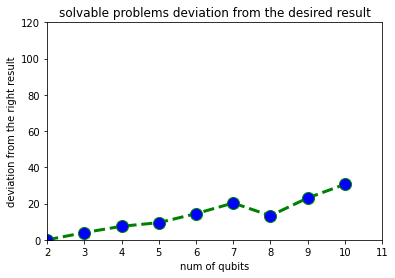

In [56]:


import matplotlib.pyplot as plt
  
# y axis values
y = avg_array_solvable
# corresponding x axis values
x = range(2,11)

print(x)
print(y)
# plotting the points 
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
  
# setting x and y axis range
plt.ylim(0,120)
plt.xlim(2,11)
  
# naming the x axis
plt.xlabel('num of qubits')
# naming the y axis
plt.ylabel('deviation from the right result')
  
# giving a title to my graph
plt.title('solvable problems deviation from the desired result')
  
# function to show the plot
plt.show()


# unsolvable problems deviation from the desired result

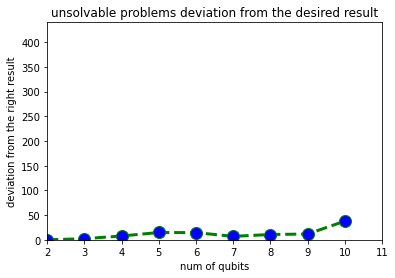

range(2, 11)
[3.3459860243251205e-05, 2.259191302013598, 7.693298107259121, 14.772351584662538, 14.507835406574618, 6.980880305777594, 10.71985926776929, 11.688642331681805, 37.737770229213396]


In [57]:
import matplotlib.pyplot as plt
  
# y axis values
y = avg_array_unsolvable
# corresponding x axis values
x = range(2,11)
  
# plotting the points 
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
  
# setting x and y axis range
plt.ylim(0,440)
plt.xlim(2,11)
  
# naming the x axis
plt.xlabel('num of qubits')
# naming the y axis
plt.ylabel('deviation from the right result')
  
# giving a title to my graph
plt.title('unsolvable problems deviation from the desired result')
  
# function to show the plot
plt.show()
print(x)
print(y)